## THE CHALLENGE: Zeta Disease Prediction

### INTRODUCTION

Mars Mission Control needs a good data-driven system for predicting Zeta Disease infection on the International Mars Colony.
Use the `_zeta-disease_training-data_` dataset to build a model that can predict who will be infected by Zeta Disease.
Apply your model to the `_zeta-disease_prediction-data_` dataset to predict who will be infected by Zeta Disease.

### DATASET

The dataset includes 9 columns with information on 800 people.
1.	age : in years
2.	weight : body weight in pounds (lbs)
3.	bmi : Body Mass Index (weight in kg/(height in m)2)
4.	blood_pressure : resting blood pressure (mm Hg)
5.	insulin_test : inuslin test value
6.	liver_stress_test : liver_stress_test value
7.	cardio_stress_test : cardio_stress_test value
8.	years_smoking : number of years of smoking
9.	zeta_disease :
              1 = yes;
              0 = no

In [391]:
# Import required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,roc_auc_score,roc_curve,recall_score
from sklearn.metrics import precision_recall_curve

In [392]:
# Read the Data
leads = pd.read_csv('2021-01-21_zeta-disease_training-data_dsi-take-home-challenge.csv')
leads.head()

age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0   54     189  27.1              80             0             1.5038   
1   23     150  38.5              68            71             0.3868   
2   47     186  29.9              90             0             0.2728   
3   18     150  30.8              70          1033             0.6598   
4   24     160  32.4              74           125             0.7608   

   cardio_stress_test  years_smoking  zeta_disease  
0                   0             10             0  
1                  55              2             0  
2                   0              7             0  
3                  56              0             0  
4                  59              2             0

# Data Preparation and EDA

In [393]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


In [394]:
leads.describe()

age      weight         bmi  blood_pressure  insulin_test  \
count  800.000000  800.000000  800.000000      800.000000    800.000000   
mean    30.985000  172.407500   32.201625       69.565000     85.887500   
std     13.824025   31.942438    8.549155       19.874784    126.333656   
min     18.000000   94.000000    0.000000        0.000000      0.000000   
25%     21.000000  149.000000   27.300000       62.000000      0.000000   
50%     26.000000  167.000000   32.050000       72.000000     45.000000   
75%     38.000000  192.000000   36.525000       80.000000    130.000000   
max    109.000000  308.000000   86.100000      157.000000   1077.000000   

       liver_stress_test  cardio_stress_test  years_smoking  zeta_disease  
count         800.000000          800.000000     800.000000    800.000000  
mean            0.544496           43.121250       4.051250      0.348750  
std             0.348711           30.409949       4.176173      0.476873  
min             0.140800            0.000000       0.000000      0.000000  
25%             0.307800            0.000000       1.000000      0.000000  
50%             0.445300           53.000000       3.000000      0.000000  
75%             0.699800           62.000000       6.000000      1.000000  
max             3.481300          214.000000      40.000000      1.000000

#### No major outliers seen in the features

In [395]:
# Check number of unique values in all columns
leads.nunique()

age                    56
weight                139
bmi                   251
blood_pressure         51
insulin_test          188
liver_stress_test     517
cardio_stress_test     57
years_smoking          22
zeta_disease            2
dtype: int64

#### Missing Values Treatment

In [396]:
# Check for missing values
round(100*leads.isnull().sum()/len(leads),2).sort_values(ascending=False)

zeta_disease          0.0
years_smoking         0.0
cardio_stress_test    0.0
liver_stress_test     0.0
insulin_test          0.0
blood_pressure        0.0
bmi                   0.0
weight                0.0
age                   0.0
dtype: float64

##### No missing values in the data 

### Check Information Value and Weight of Evidence (WOE) of Predictors

In [397]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

## Interpreting information value
- Information value	Predictive power
- < 0.02 -	useless for prediction
- 0.02 - 0.1 -	weak predictor
- 0.1 - 0.3 - 	medium predictor
- 0.3 - 0.5	 - strong predictor
- greater than 0.5 - suspicious or too good

In [398]:
final_leads, IV = data_vars(leads,leads.zeta_disease)
IV

VAR_NAME        IV
0                 age  0.488045
1      blood_pressure  0.077748
2                 bmi  0.534852
3  cardio_stress_test  0.080212
4        insulin_test  0.000174
5   liver_stress_test  0.089509
6              weight  1.279364
7       years_smoking  0.238457

#### We can see weight,age,bmi are strong predictors. But Insulin_test has very less information value.

In [399]:
# Checking WOE across multiple bins of Weight. Its clearly showing a pattern of higher event rate(Zeta Disease) 
# with increase in weight
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
col='weight'
sns.barplot(x=final_leads[final_leads.VAR_NAME==col]['MIN_VALUE'],y=final_leads[final_leads.VAR_NAME==col]['WOE'])
plt.xlabel(col)

Text(0.5, 0, 'weight')

Text(0.5, 0, 'age')

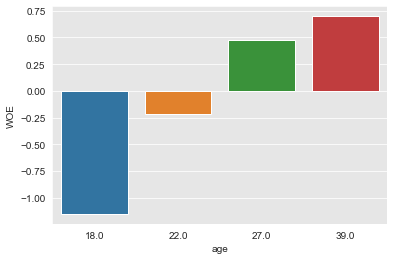

In [400]:
# Checking WOE across multiple bins of age. Its clearly showing a pattern of higher event rate(Zeta Disease) 
# with increase in age
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
col='age'
sns.barplot(x=final_leads[final_leads.VAR_NAME==col]['MIN_VALUE'],y=final_leads[final_leads.VAR_NAME==col]['WOE'])
plt.xlabel(col)

Text(0.5, 0, 'bmi')

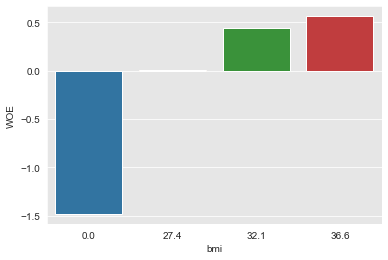

In [401]:
# Checking WOE across multiple bins of bmi. Its clearly showing a pattern of higher event rate(Zeta Disease) 
# with increase in bmi
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
col='bmi'
sns.barplot(x=final_leads[final_leads.VAR_NAME==col]['MIN_VALUE'],y=final_leads[final_leads.VAR_NAME==col]['WOE'])
plt.xlabel(col)

### Univariate and Bivariate Analysis of predictors

In [402]:
leads.head()

age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0   54     189  27.1              80             0             1.5038   
1   23     150  38.5              68            71             0.3868   
2   47     186  29.9              90             0             0.2728   
3   18     150  30.8              70          1033             0.6598   
4   24     160  32.4              74           125             0.7608   

   cardio_stress_test  years_smoking  zeta_disease  
0                   0             10             0  
1                  55              2             0  
2                   0              7             0  
3                  56              0             0  
4                  59              2             0

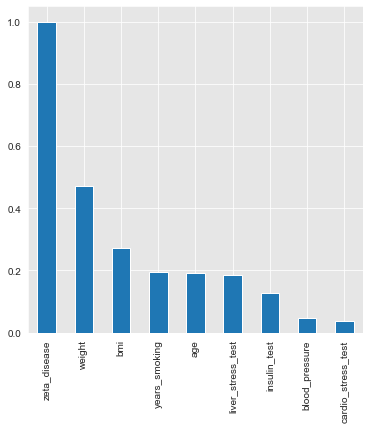

In [403]:
# Check correlation of Zeta Disease with other features
leads.corr()['zeta_disease'].sort_values(ascending=False).plot(kind='bar',figsize=(6,6))

##### We can see higher correlation for Weight,BMI with target Zeta_disease variable

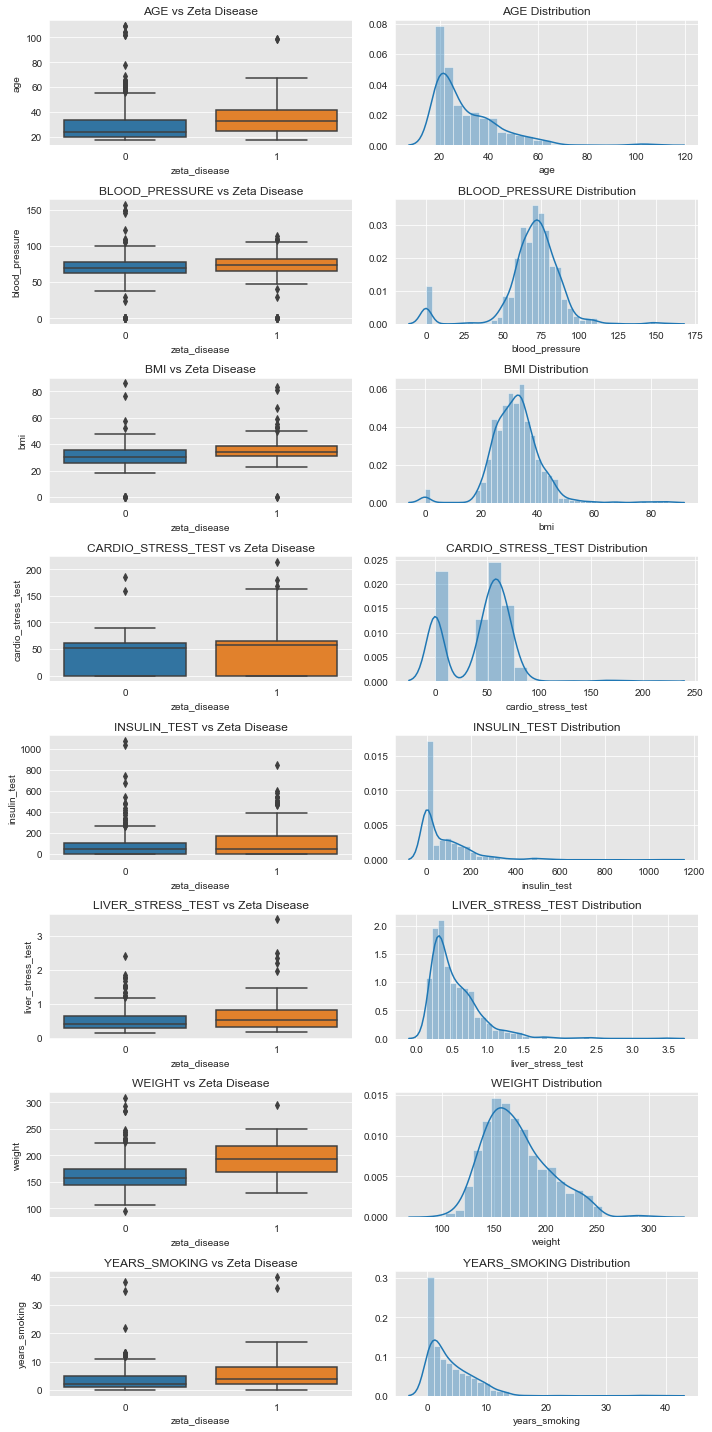

In [404]:
# Checking conversion count relation with numerical variables
plt.figure(figsize=(10,20))
for i,col in enumerate(leads.columns.difference(['zeta_disease'])):
    plt.subplot(8,2,2*i+1)
    sns.boxplot(x='zeta_disease',y=col,data=leads)
    plt.title(col.upper() + ' vs Zeta Disease')
    plt.subplot(8,2,2*i+2)
    sns.distplot(leads[col])
    plt.title(col.upper() + ' Distribution')
plt.tight_layout()

#### Lot of values are zeros for insulin_test and cardio_stress_test probably because values are missing or test was not done.This could add bias to the model. We will impute them using Iterative Imputer.

In [405]:
pd.Series(leads.insulin_test == 0).value_counts()

False    430
True     370
Name: insulin_test, dtype: int64

In [406]:
pd.Series(leads.cardio_stress_test == 0).value_counts()

False    573
True     227
Name: cardio_stress_test, dtype: int64

In [407]:
pd.Series(leads.insulin_test.isna()).value_counts()

False    800
Name: insulin_test, dtype: int64

In [408]:
pd.Series(leads.cardio_stress_test.isna()).value_counts()

False    800
Name: cardio_stress_test, dtype: int64

In [409]:
# Mark zeros as np.nan
leads['cardio_stress_test'] = leads['cardio_stress_test'].replace({0:np.nan})
leads['insulin_test'] = leads['insulin_test'].replace({0:np.nan})

In [410]:
pd.Series(leads.insulin_test == 0).value_counts()

False    800
Name: insulin_test, dtype: int64

In [411]:
pd.Series(leads.cardio_stress_test == 0).value_counts()

False    800
Name: cardio_stress_test, dtype: int64

In [412]:
pd.Series(leads.insulin_test.isna()).value_counts()

False    430
True     370
Name: insulin_test, dtype: int64

In [413]:
pd.Series(leads.cardio_stress_test.isna()).value_counts()

False    573
True     227
Name: cardio_stress_test, dtype: int64

In [414]:
# We see all columns are numerical columns
# We will use Iterative imputer to fill missing values
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
impute = IterativeImputer(n_nearest_features=5,min_value=0,random_state=100)
leads_imputed = impute.fit_transform(leads)

In [415]:
leads = pd.DataFrame(data=leads_imputed,columns=leads.columns)
leads.head()

age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0  54.0   189.0  27.1            80.0    173.308511             1.5038   
1  23.0   150.0  38.5            68.0     71.000000             0.3868   
2  47.0   186.0  29.9            90.0    173.730902             0.2728   
3  18.0   150.0  30.8            70.0   1033.000000             0.6598   
4  24.0   160.0  32.4            74.0    125.000000             0.7608   

   cardio_stress_test  years_smoking  zeta_disease  
0           57.417609           10.0           0.0  
1           55.000000            2.0           0.0  
2           58.950704            7.0           0.0  
3           56.000000            0.0           0.0  
4           59.000000            2.0           0.0

In [416]:
pd.Series(leads.insulin_test.isna()).value_counts()

False    800
Name: insulin_test, dtype: int64

In [417]:
pd.Series(leads.cardio_stress_test.isna()).value_counts()

False    800
Name: cardio_stress_test, dtype: int64

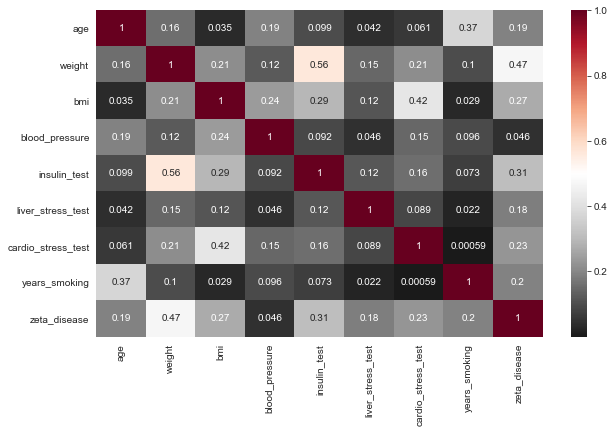

In [418]:
# Check correlation between variables
plt.figure(figsize=(10,6))
sns.heatmap(leads.corr(),annot=True,cmap='RdGy_r')

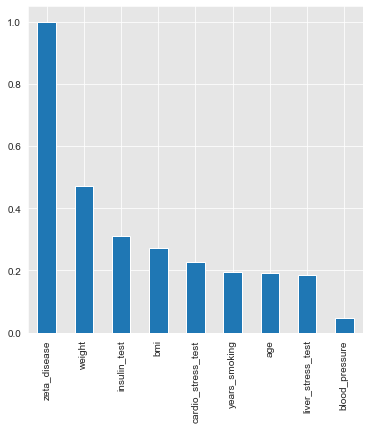

In [419]:
# Check correlation of Zeta Disease with other features
leads.corr()['zeta_disease'].sort_values(ascending=False).plot(kind='bar',figsize=(6,6))

### Findings :-
- Median values for Age,BMI,weight,years smoking is considerable higher for Zeta Disease people compared to healthy people.
- Post Imputation correlation of insulin_test and cardio_stress_test with Zeta Disease has increased.
- Some of the features are left/right skewed. We need to apply box cox transformation in case we are planning to apply parametric models like logistic regression.
- High positive correlation seen between weight and insulin_test.
- High positive correlation seen between bmi and cardio stress test.

# Modeling

- We will be using tree based models hence outlier treatment and data scaling  would not be needed.
- We will check for Dataset Imbalance prior to modelling 
- We will split the training data to train and test. 
- For validation we will use K-fold cross validation with model hyperparameter tuning

In [420]:
y=leads['zeta_disease']
X=leads.drop(['zeta_disease'],axis=1)

In [421]:
# Train test split with Stratification done using y variable
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=100)

In [422]:
X_train.shape

(640, 8)

In [423]:
X_test.shape

(160, 8)

Text(0, 0.5, 'Percentage')

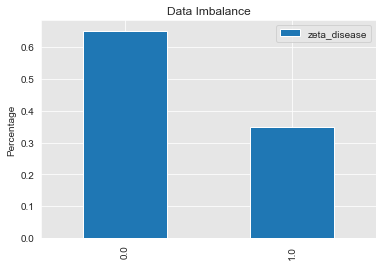

In [424]:
# Data Imbalance Check
pd.DataFrame(y_train.value_counts()/len(y_train)).plot(kind='bar',title='Data Imbalance')
plt.ylabel('Percentage')

###  SMOTE for Data balancing

In [425]:
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

Text(0, 0.5, 'Percentage')

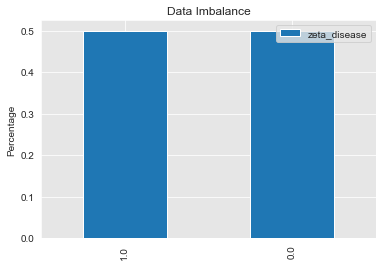

In [426]:
# Data Imbalance Check post SMOTE oversampling
pd.DataFrame(y_train_smote.value_counts()/len(y_train_smote)).plot(kind='bar',title='Data Imbalance')
plt.ylabel('Percentage')

##### Data is balanced now.

In [427]:
# Helper Function to display model Evaluation Metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report

def evaluation_metrics(y_test,y_test_pred,y_test_pred_prob):
    print("Classification Report: \n\n" ,classification_report(y_test,y_test_pred))
    print("ROC AUC Score:", roc_auc_score(y_test,y_test_pred_prob))
    
    fpr, tpr, thresholds = roc_curve( y_test, y_test_pred_prob,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( y_test, y_test_pred_prob )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.tight_layout()
     

In [428]:
# XG Boost Model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params = {"n_estimators":[50,100,150],"learning_rate":[0.01,0.1,0.3],'min_child_weight':[1,6,8],
         'max_depth':[7,8,10,12,15],'subsample':[i/10.0 for i in range(6,10)]}


xgb = XGBClassifier(objective= 'binary:logistic')
xgb_gs = GridSearchCV(estimator=xgb,param_grid=params,cv=3,n_jobs=-1,return_train_score=True,scoring='roc_auc')
xgb_gs.fit(X_train_smote,y_train_smote)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid=

In [429]:
#Best Estimator
xgb_gs.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
              validate_parameters=False, verbosity=None)

In [430]:
#Best parameters
xgb_gs.best_params_

{'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.9}

In [431]:
#Best Score
xgb_gs.best_score_

0.8839777099183962

In [432]:
# Make prediction on train dataset
y_train_pred_xgb = xgb_gs.predict(X_train)
y_train_pred_prob_xgb = xgb_gs.predict_proba(X_train)
roc_auc_score(y_train, y_train_pred_prob_xgb[:,1])

0.9999677388134336

In [433]:
# Make prediction on test dataset
y_test_pred_xgb = xgb_gs.predict(X_test)
y_test_pred_prob_xgb = xgb_gs.predict_proba(X_test)

Classification Report: 

               precision    recall  f1-score   support

         0.0       0.80      0.79      0.80       104
         1.0       0.62      0.64      0.63        56

    accuracy                           0.74       160
   macro avg       0.71      0.72      0.71       160
weighted avg       0.74      0.74      0.74       160

ROC AUC Score: 0.8149038461538461


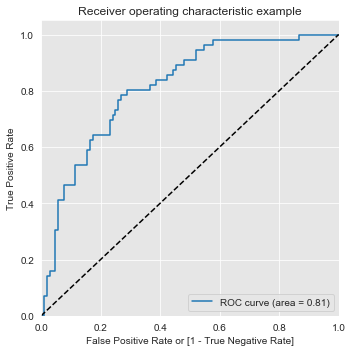

In [434]:
# Model Evaluation parameters of best Logistic Regression Model
evaluation_metrics(y_test,y_test_pred_xgb,y_test_pred_prob_xgb[:,1])

In [435]:
# Naive Bayes Model
from sklearn.naive_bayes import GaussianNB

params = {'var_smoothing': [0.1,0.3,0.5,0.6,0.7,0.8]}

gnb = GaussianNB()

gnb_gs = GridSearchCV(estimator=gnb,param_grid=params,cv=3,n_jobs=-1,return_train_score=True,scoring='roc_auc')
gnb_gs.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=3, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=-1,
             param_grid={'var_smoothing': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [436]:
#Best Estimator
gnb_gs.best_estimator_

GaussianNB(priors=None, var_smoothing=0.1)

In [437]:
#Best parameters
gnb_gs.best_params_

{'var_smoothing': 0.1}

In [438]:
#Best Score
gnb_gs.best_score_

0.7980953366802961

In [439]:
# Make prediction on train dataset
y_train_pred_gnb = gnb_gs.predict(X_train)
y_train_pred_prob_gnb = gnb_gs.predict_proba(X_train)
roc_auc_score(y_train, y_train_pred_prob_gnb[:,1])

0.7935714208901938

In [440]:
# Make prediction on test dataset
y_test_pred_gnb = gnb_gs.predict(X_test)
y_test_pred_prob_gnb = gnb_gs.predict_proba(X_test)

Classification Report: 

               precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       104
         1.0       0.62      0.55      0.58        56

    accuracy                           0.73       160
   macro avg       0.70      0.69      0.69       160
weighted avg       0.72      0.72      0.72       160

ROC AUC Score: 0.8128434065934066


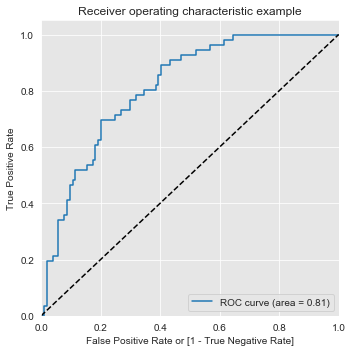

In [441]:
# Model Evaluation parameters of best Logistic Regression Model
evaluation_metrics(y_test,y_test_pred_gnb,y_test_pred_prob_gnb[:,1])

In [442]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000,100000]}
lr = LogisticRegression()


lr_gs = GridSearchCV(estimator=lr,param_grid=params,cv=3,n_jobs=-1,return_train_score=True,scoring='roc_auc')
lr_gs.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [443]:
#Best Estimator
lr_gs.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [444]:
#Best parameters
lr_gs.best_params_

{'C': 1, 'penalty': 'l2'}

In [445]:
# Make prediction
y_test_pred_lr = lr_gs.predict(X_test)
y_test_pred_prob_lr = lr_gs.predict_proba(X_test)

Classification Report: 

               precision    recall  f1-score   support

         0.0       0.78      0.75      0.76       104
         1.0       0.57      0.61      0.59        56

    accuracy                           0.70       160
   macro avg       0.67      0.68      0.68       160
weighted avg       0.71      0.70      0.70       160

ROC AUC Score: 0.7615041208791209


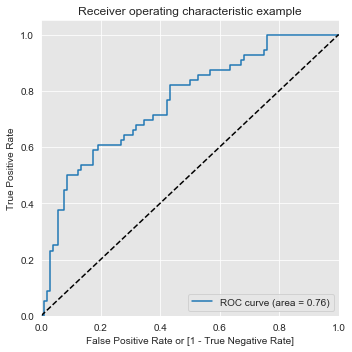

In [446]:
# Model Evaluation parameters of best Logistic Regression Model
evaluation_metrics(y_test,y_test_pred_lr,y_test_pred_prob_lr[:,1])

In [447]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grid search parameters
folds=5
params = {'max_depth':[8,12,16],
            'n_estimators' : [400,800],
            'max_features' : [4,8],
            'min_samples_leaf' : [20,25,35],
            'max_samples':[0.25,0.50,0.75]}

rf = RandomForestClassifier(random_state=100,n_jobs=-1,verbose=True)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,cv=folds,n_jobs=-1,return_train_score=True,scoring='roc_auc')
gs_rf.fit(X_train_smote,y_train_smote)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=100,
                                   

In [448]:
#Best Estimator
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=4,
                       max_leaf_nodes=None, max_samples=0.75,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=100,
                       verbose=True, warm_start=False)

In [449]:
#Best parameters
gs_rf.best_params_

{'max_depth': 8,
 'max_features': 4,
 'max_samples': 0.75,
 'min_samples_leaf': 20,
 'n_estimators': 800}

In [450]:
#Best parameters
gs_rf.best_score_

0.8610448679399181

In [451]:
# Make prediction
y_test_pred_rf = gs_rf.predict(X_test)
y_test_pred_prob_rf = gs_rf.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.1s finished


Classification Report: 

               precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       104
         1.0       0.63      0.71      0.67        56

    accuracy                           0.76       160
   macro avg       0.73      0.75      0.74       160
weighted avg       0.77      0.76      0.76       160

ROC AUC Score: 0.8413461538461539


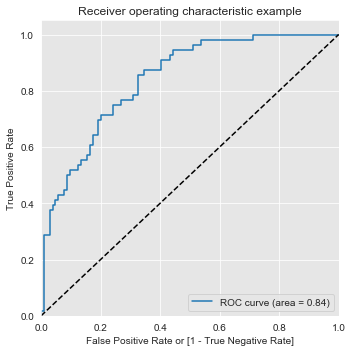

In [452]:
# Model Evaluation parameters of best Logistic Regression Model
evaluation_metrics(y_test,y_test_pred_rf,y_test_pred_prob_rf[:,1])

In [453]:
rf = RandomForestClassifier(max_depth=8,random_state=100,n_jobs=-1,verbose=True)
rf.fit(X_train_smote,y_train_smote)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=100,
                       verbose=True, warm_start=False)

Text(0.5, 0, 'Random Forest Feature Importance')

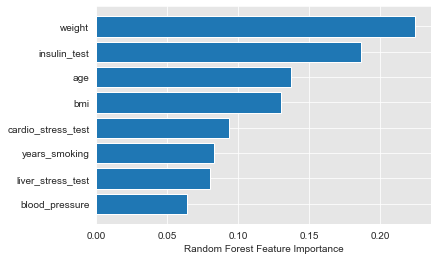

In [454]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train_smote.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Finding Optimal Cutoff Point

In [455]:
# Create Dataframe
y_test_pred_final = pd.DataFrame({'Actual':y_test,'Predicted':y_test_pred_rf,'Probability':y_test_pred_prob_rf[:,1]})
y_test_pred_final.head()

Actual  Predicted  Probability
14      1.0        1.0     0.688434
297     1.0        0.0     0.460406
80      0.0        1.0     0.641301
391     1.0        1.0     0.925482
598     1.0        1.0     0.705319

In [456]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Probability.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

Actual  Predicted  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
14      1.0        1.0     0.688434    1    1    1    1    1    1    1    0   
297     1.0        0.0     0.460406    1    1    1    1    1    0    0    0   
80      0.0        1.0     0.641301    1    1    1    1    1    1    1    0   
391     1.0        1.0     0.925482    1    1    1    1    1    1    1    1   
598     1.0        1.0     0.705319    1    1    1    1    1    1    1    1   

     0.8  0.9  
14     0    0  
297    0    0  
80     0    0  
391    1    1  
598    0    0

In [457]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_test_pred_final.Actual, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensitivity  specificity
0.0   0.0   0.35000     1.000000     0.000000
0.1   0.1   0.49375     1.000000     0.221154
0.2   0.2   0.59375     0.982143     0.384615
0.3   0.3   0.70000     0.875000     0.605769
0.4   0.4   0.72500     0.785714     0.692308
0.5   0.5   0.75625     0.714286     0.778846
0.6   0.6   0.74375     0.571429     0.836538
0.7   0.7   0.75625     0.446429     0.923077
0.8   0.8   0.73750     0.303571     0.971154
0.9   0.9   0.66875     0.071429     0.990385


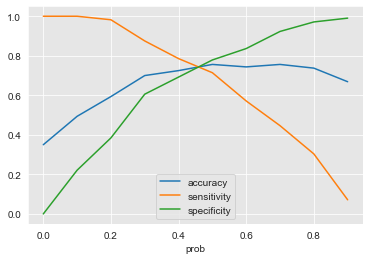

In [458]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

#### From the curve above, around 0.5 is the optimum point to take it as a cutoff probability.

## Findings :
 1. Random Forest best classifies the data with ROC-AUC score of 0.84 on test data.
 2. The optimal cut off probability was found to be 0.5.

# Prediction on External Data

In [459]:
# Load the test data
leads_test = pd.read_csv('2021-01-21_zeta-disease_prediction-data_dsi-take-home-challenge.csv')
leads_test.head()

age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0   24     151  39.5              69            72             1.3968   
1   27     179  35.5              89           156             1.6608   
2   34     147  26.9              76            74             1.6958   
3   35     206  32.4              73           127             1.4608   
4   60     193  29.8              62           192             1.7798   

   cardio_stress_test  years_smoking  zeta_disease  
0                  56              4           NaN  
1                  43              6           NaN  
2                  53              2           NaN  
3                  61              6           NaN  
4                  65              9           NaN

In [460]:
# Predict using Tuned final Random Forest Model on external test Data
leads_test['zeta_disease'] = gs_rf.predict(leads_test.drop('zeta_disease',axis=1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished


In [461]:
leads_test

age  weight   bmi  blood_pressure  insulin_test  liver_stress_test  \
0    24     151  39.5              69            72             1.3968   
1    27     179  35.5              89           156             1.6608   
2    34     147  26.9              76            74             1.6958   
3    35     206  32.4              73           127             1.4608   
4    60     193  29.8              62           192             1.7798   
5    45     120  36.5             108            50             1.2978   
6    20     139  38.2              61            77             1.5818   
7    23     137  31.2              70            73             1.4168   
8    36     195  30.5              59           141             1.4498   
9    19     193  25.8              84            66             1.7938   
10   47     216  34.7              70           170             1.7238   
11   40     200  30.4              69           128             1.3118   
12   21     154  46.5              88           121             1.2498   
13   52     196  31.3              90           167             1.9238   
14   30     181  37.4              93           157             2.0508   
15   46     213  26.5              70           133             1.4788   
16   29     173  50.7              91           221             1.4878   
17   36     202  42.8              72           273             1.8748   
18   27     197  29.1              72           362             1.4298   
19   44     184  33.9             104           141             1.3268   

    cardio_stress_test  years_smoking  zeta_disease  
0                   56              4           0.0  
1                   43              6           1.0  
2                   53              2           0.0  
3                   61              6           1.0  
4                   65              9           1.0  
5                   54             12           0.0  
6                   68              3           0.0  
7                   59              7           0.0  
8                   59              6           1.0  
9                   50              3           0.0  
10                  58              7           1.0  
11                  60              3           1.0  
12                  68              4           0.0  
13                  66             10           1.0  
14                  80              5           1.0  
15                  55             12           1.0  
16                  83              3           1.0  
17                  72             13           1.0  
18                  69              4           1.0  
19                  60              2           1.0